In [1]:
!nvidia-smi

Wed Aug 17 23:47:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   49C    P2    97W / 260W |  22366MiB / 24576MiB |     39%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     On   | 00000000:1C:00.0 Off |                  Off |
| 54%   

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

from GradCAM import *
from define_model import *
from load_label import *
from utilities import *
from Parse_TFrecords import *
import gc
import tensorflow as tf
import json
import glob
import matplotlib.image as mpimg


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
from sklearn.metrics import classification_report, average_precision_score

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
print(gpus)
 
print(tf.__version__)

[]
2.8.0


In [3]:
def parse_TFrecord_train_demo(example):
    img = tf.io.parse_single_example(example, {'jpg_bytes': tf.io.FixedLenFeature([], tf.string)}) # Parse images to keras dataset
    img = tf.io.decode_jpeg(img['jpg_bytes'], channels=3) #RBG image
    # Normalize the pixel values to be between 0 and 1
    img = (1.0 / 255.0) * tf.cast(tf.image.resize(img, [256, 256]), tf.float16) #Normalize pixel 
    
    copd = tf.io.parse_single_example(example, {'COPD' :tf.io.FixedLenFeature([], tf.int64)}) # parses the label copd

    if (tf.math.equal(copd['COPD'], 0)):
        label = tf.constant(0)
    elif(tf.math.equal(copd['COPD'], 1)):
        label = tf.constant(1) 
    else:
        label = tf.constant(-1)
        
    race = tf.cast(tf.io.parse_single_example(example, {'race' :tf.io.FixedLenFeature([], tf.int64)})['race'], tf.int32)
    age = tf.cast(tf.io.parse_single_example(example, {'age' :tf.io.FixedLenFeature([], tf.int64)})['age'], tf.int32)
    gender = tf.cast(tf.io.parse_single_example(example, {'gender' :tf.io.FixedLenFeature([], tf.int64)})['gender'], tf.int32)
        
    age = tf.one_hot(age, 4)
    race = tf.one_hot(race, 5)
    
    demo = tf.experimental.numpy.append(tf.cast(race, tf.float32), tf.cast(age, tf.float32))
    demo = tf.experimental.numpy.append(tf.cast(demo, tf.float32), tf.cast(gender, tf.float32))

    feature_dict = collections.OrderedDict(
      input_cxr=img,
      input_demo=demo
  )

    return feature_dict, label

In [29]:
BATCH_SIZE = 32
dataset = 'mimic'

record_file_test = 'tfrecords/copd_{a}_test.tfrecords'.format(a=dataset)
test_dataset = (tf.data.TFRecordDataset(
    record_file_test, buffer_size=BATCH_SIZE, compression_type=None, num_parallel_reads=32)
.map(parse_TFrecord_train_demo))

In [31]:
# archis = ['DenseNet121', 'DenseNet201', 'ResNet50V2', 'ResNet152V2', 'Xception', 'InceptionV3', 'InceptionResNetV2', 'MobileNetV2']
archis = ['Xception']
data = 'mimic'

split = 'test'

df = pd.DataFrame()

for i in archis:
    outfile = 'preds/{d}/{j}_preds/fusion_{i}_preds.npy'.format(d=data,j=split, i=i)

    df[i] = np.reshape(np.load(outfile), (-1)).tolist()
    
y_label = get_data_label('mimic', split)
idx_0 = np.where(y_label==0)[0]
idx_1 = np.where(y_label==1)[0]
thresh = get_thresh(y_label, df['Xception'], 'Youden')
idx2draw_0 = df.iloc[idx_0].loc[df['Xception'] >= thresh].index.values
idx2draw_1 = df.iloc[idx_1].loc[df['Xception'] >= thresh].index.values

In [7]:
filename = 'tfrecords/copd_emory_test.tfrecords'

paths = []
subject_ids = []

#load the test files
raw_dataset = tf.data.TFRecordDataset(filename)
for raw_record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    paths.append(example.features.feature['hiti_path'].bytes_list.value[0].decode('utf-8'))
    subject_ids.append(example.features.feature['subject_id'].int64_list.value[0])

In [8]:
df_False_Positive = pd.DataFrame()
df_False_Negative = pd.DataFrame()

df_False_Positive['ID'] = np.array(subject_ids)[idx2draw_0]
df_False_Positive['Path'] = np.array(paths)[idx2draw_0]
df_False_Positive['Pred'] = df.iloc[idx2draw_0].values
df_False_Positive.to_csv('False_positive_cases.csv')

df_False_Negative['ID'] = np.array(subject_ids)[idx2draw_1]
df_False_Negative['Path'] = np.array(paths)[idx2draw_1]
df_False_Negative['Pred'] = df.iloc[idx2draw_1].values
df_False_Negative.to_csv('False_Negative_cases.csv')

In [32]:
def get_model_demo(archi):
    Input = tf.keras.Input(shape=(10,), name='input_demo') # age - 4, race - 5

    base_model = load_model_from_pretrain(archi)
    checkpoint_filepath = 'checkpoints_mimic/checkpoint_BCE_{i}'.format(i=archi)

    base_model.load_weights(checkpoint_filepath)

    base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(base_model.layers[-2].name).output)

    cxr_model = tf.keras.Sequential()
    cxr_model.add(base_model)
    cxr_model.add(tf.keras.layers.Dense(64, name='cxr_embeddings'))

    cxr_model.layers[0]._name = 'base_model'

    combined = tf.keras.layers.concatenate([cxr_model.output, Input], name='fusion_layer')
    pred_COPD = tf.keras.layers.Dense(1, activation='sigmoid', name='pred_COPD')(combined)

    model = tf.keras.Model(inputs=[cxr_model.input, Input], outputs=pred_COPD)
    model.layers[0]._name = 'input_cxr'

    print(model.summary())
    
    return model


In [33]:
checkpoint_filepath = 'checkpoints_fusion/checkpoint_Xception_demo_64'

model = get_model_demo('Xception')
model.load_weights(checkpoint_filepath)

cxr_input = model.get_layer('input_cxr')
demo_input = model.get_layer('input_demo')
base_model = model.get_layer('base_model')
cxr_embeddings = model.get_layer('cxr_embeddings')
fusion_layer = model.get_layer('fusion_layer')
pred_COPD = model.get_layer('pred_COPD')

# For GradCam

# First, we create a model that maps the input image to the activations
# of the last conv layer
last_conv_layer = base_model.get_layer(base_model.layers[-2].name)
last_conv_layer_model = tf.keras.Sequential()
last_conv_layer_model.add(cxr_input)
last_conv_layer_model.add(tf.keras.Model(base_model.inputs, last_conv_layer.output))

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions


classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in base_model.layers[-1:]:
    x = base_model.get_layer(layer_name.name)(x)
    
x = cxr_embeddings(x)
x = fusion_layer([x, demo_input.output])
x = pred_COPD(x)
classifier_model = tf.keras.Model([classifier_input, demo_input.input] , x)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_cxr (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 base_model (Functional)        (None, 2048)         20861480    ['input_cxr[0][0]']              
                                                                                                  
 cxr_embeddings (Dense)         (None, 64)           131136      ['base_model[0][0]']             
                                                                                                  
 input_demo (InputLayer)        [(None, 10)]         0           []                         

In [80]:
# checkpoint_filepath = 'checkpoints_fusion/checkpoint_Xception_demo_64'
checkpoint_filepath = 'checkpoints_mimic/checkpoint_BCE_Xception'


model = define_model('Xception')
model.load_weights(checkpoint_filepath)

# For GradCam

# First, we create a model that maps the input image to the activations
# of the last conv layer
last_conv_layer = model.get_layer(model.layers[-3].name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in model.layers[-2:]:
    x = model.get_layer(layer_name.name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm
from skimage.transform import resize

def make_gradcam_heatmap(img_array, label_array, last_conv_layer_model, classifier_model, target_class=None):

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model([last_conv_layer_output, label_array])
        
        if (target_class is not None):
            top_pred_index = tf.constant(target_class)
        else:
            top_pred_index = tf.argmax(preds[0])
        
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

def show_heatmap(img_array, label_array, last_conv_layer_model, classifier_model, target_class=None):

    heatmap = make_gradcam_heatmap(img_array, label_array, last_conv_layer_model, classifier_model, target_class)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
   

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((256, 256))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    return ((jet_heatmap/255)*0.4+img_array)

In [35]:
heat_map = []
preds = []
img = []
ids = []
for idx, (i, l) in enumerate(test_dataset):
    if (idx not in idx2draw_1):
        continue

    img_array = np.reshape(i['input_cxr'], (1, 256, 256, 3))
    label_array = np.reshape(i['input_demo'], (1, 10))
    pred = model.predict([img_array, label_array])
    
    if (pred[0][0] >= 0.9):
        
        img.append(img_array)
        heat_map.append(show_heatmap(img_array, label_array, last_conv_layer_model, classifier_model))
        preds.append(pred)
    #     ids.append(idx)
    else:
        continue
                        
preds = np.array(preds).reshape(len(preds,))
ids = np.array(ids).reshape(len(ids,))
order = np.argsort(np.array(preds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99958503


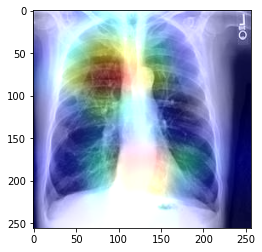

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9995956


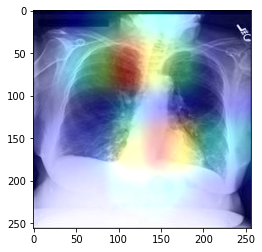

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99966085


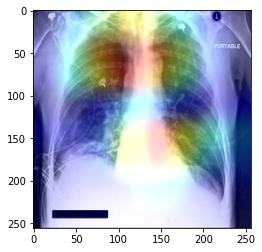

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99987185


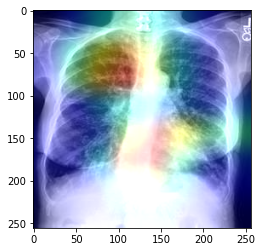

In [36]:
for i in order[-4:]:
    print(preds[i])
    plt.imshow(np.reshape(heat_map[i], (256, 256, 3)))
#     fname = 'imgs_mobilenet/imgs_mimic/emory/{a}_{b}_gradcam.jpg'.format(d=dataset, a=ids[i], b=preds[i])
#     plt.savefig(fname)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


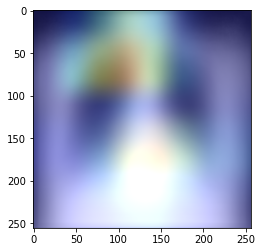

In [37]:
mean_heatmap = np.mean(heat_map, axis=0)
plt.imshow(np.reshape(mean_heatmap, (256, 256, 3)))
# fname = 'imgs_xception/imgs_merged/emory/mean_gradcam.jpg'.format(a=ids[i], b=preds[i])
# plt.savefig(fname)
plt.show()

In [47]:
path = 'imgs/imgs_mimic/internal/imgs_{i}/'.format(i=dend['ivl'][int((a-5)/10)])
files = os.listdir(path)
val_a = mpimg.imread(path + files[0])

# Mann-Whitney test

In [80]:
archis = ['DenseNet121', 'DenseNet201', 'ResNet50V2', 'ResNet152V2', 'Xception', 'InceptionV3', 'InceptionResNetV2', 'MobileNetV2']
data = 'mimic'
split = 'test'

df = pd.DataFrame()

for i in archis:
    outfile = 'preds/{d}/{j}_preds/{i}_preds.npy'.format(d=data,j=split, i=i)

    df[i] = np.reshape(np.load(outfile), (-1)).tolist()
    
y_label = get_data_label('mimic', split)

In [84]:
label_0 = np.where(y_label==0)[0]
label_1 = np.where(y_label==1)[0]

df_0 = df.iloc[label_0]
df_1 = df.iloc[label_1]

<AxesSubplot:title={'center':'Mann–Whitney U test'}>

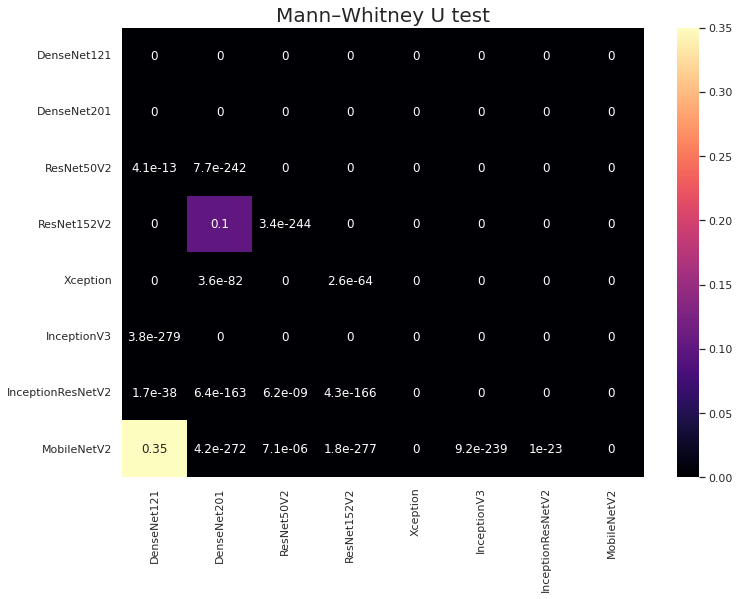

In [139]:
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats

mat = [[0 for _ in range (len(archis))] for _ in range(len(archis))]

for i in range(len(archis)):
    for j in range(i+1, len(archis)):
        u1, p = mannwhitneyu(df[archis[j]], df[archis[i]])
        mat[j][i] = p

sns.set(rc={'figure.figsize':(11.7,8.27)})

# plt.matshow(np.array(mat))
plt.title('Mann–Whitney U test', fontsize = 20)
sns.heatmap(np.array(mat), annot=True, xticklabels=archis, yticklabels=archis, cmap='magma')

<AxesSubplot:title={'center':'T-test'}>

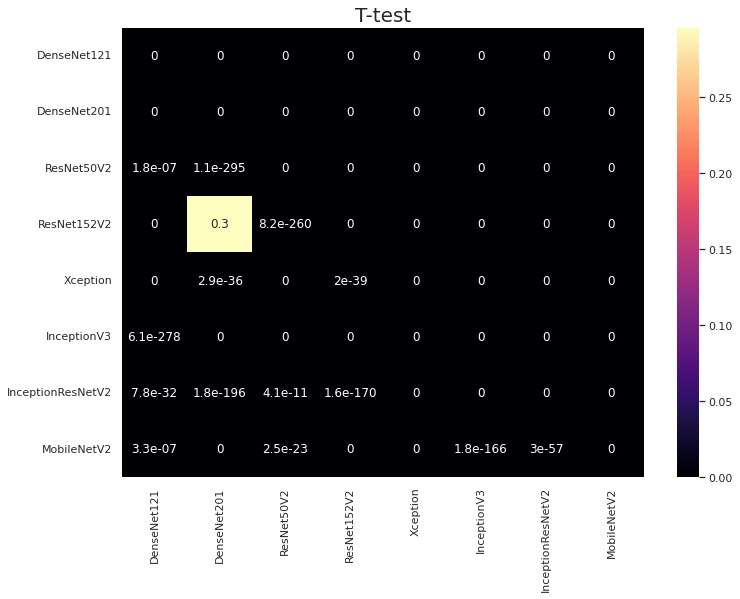

In [162]:
mat = [[0 for _ in range (len(archis))] for _ in range(len(archis))]

for i in range(len(archis)):
    for j in range(i+1, len(archis)):
        s, p = stats.ttest_ind(df[archis[j]], df[archis[i]], equal_var=False)
        mat[j][i] = p

sns.set(rc={'figure.figsize':(11.7,8.27)})

# plt.matshow(np.array(mat))
plt.title('T-test', fontsize = 20)
sns.heatmap(np.array(mat), annot=True, xticklabels=archis, yticklabels=archis, cmap='magma')

## Saliency Map

In [ ]:
def get_saliency_map(model, image):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = model(image)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)

    dgrad_abs = tf.math.abs(gradient)
#         print(dgrad_abs.shape)
    dgrad_max_ = np.max(dgrad_abs, axis=-1)[0]
#         print(dgrad_max_.shape)

    # normaliz between 0 and 1
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    smap = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    return smap

In [ ]:
linear_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-1].output)
for i in order[-20:]:
    print(preds[i])
    smap = get_saliency_map(linear_model, tf.Variable(img[i], dtype=float))

    plt.subplot(1, 2, 1)
    plt.imshow(img[i][0])

    plt.subplot(1, 2, 2)
    plt.imshow(smap, cmap='Reds')

    plt.show()

In [ ]:
smaps = []
for i in range(len(img)):
    smaps.append(get_saliency_map(linear_model, tf.Variable(img[i], dtype=float)))

In [ ]:
mean_img = np.mean(img, axis=0)
plt.subplot(1, 2, 1)
plt.imshow(mean_img[0], cmap='gray')

mean_smap = np.mean(smaps, axis=0)
plt.subplot(1, 2, 2)
plt.imshow(mean_smap, cmap='Reds')

plt.show()